<a href="https://colab.research.google.com/github/juansebastiangit/Inteligencia_artificial/blob/main/TAM/Talleres/Regresores/Taller_regresores_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller 1 TAM - Regresores

**Ejercicio 1 - Demostración de la probabilidad p(t)**

**Ejercicio 2 - Demostracion de la probabilidad condicional p(t|f(x),f(X))**

**Ejercicio 3 - Combinaciones de Kernels**

*Cargamos todo como esta en el cuaderno original*

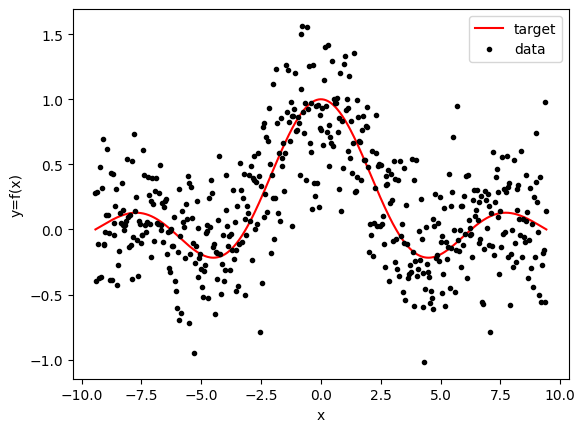

In [5]:

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
N = 500 #número de muestras
X = np.linspace(-3*np.pi,3*np.pi,N) #vector de entrada
y = np.sinc(X/np.pi) #función sinc -> objetivo
var = 0.1 #varianza del ruido
mue = 0 #media del ruido
noise = mue + np.sqrt(var)*np.random.randn(X.shape[0])#ruido blanco
yn = y + noise #señal co ruido
plt.plot(X,y,'r',label='target' )
plt.plot(X,yn,'k.',label='data')
plt.legend()
plt.xlabel('x')
plt.ylabel('y=f(x)')
plt.show()

In [6]:
ydata = yn.reshape(-1,1)
Xdata = X.reshape(-1,1)
print(Xdata.shape) # N = 500 muestras, P = 1 atributos
print(ydata.shape) # N = 500, regresion univarida

(500, 1)
(500, 1)


0
(350, 1)
(150, 1)


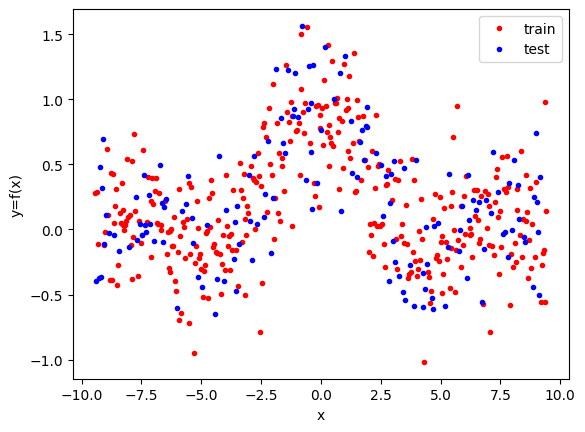

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict,ShuffleSplit

#particionar datos
rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.3)
for i, (train_i, test_i) in enumerate(rs.split(X)):
   print(i)


X_train, X_test, y_train, y_test = Xdata[train_i], Xdata[test_i], ydata[train_i], ydata[test_i]

print(X_train.shape)
print(X_test.shape)

plt.plot(X_train,y_train,'r.',label='train' )
plt.plot(X_test,y_test,'b.',label='test')
plt.legend()
plt.xlabel('x')
plt.ylabel('y=f(x)')
plt.show()

In [8]:
import matplotlib.pyplot as plt
import numpy as np


def plot_gpr_samples(gpr_model, X, x, n_samples, ax,xlabel_="x",ylabel_="y"):
    """Plot samples drawn from the Gaussian process model.

    If the Gaussian process model is not trained then the drawn samples are
    drawn from the prior distribution. Otherwise, the samples are drawn from
    the posterior distribution. Be aware that a sample here corresponds to a
    function.

    Parameters
    ----------
    gpr_model : `GaussianProcessRegressor`
        A :class:`~sklearn.gaussian_process.GaussianProcessRegressor` model.
    X: input samples in N x P
    n_samples : int
        The number of samples to draw from the Gaussian process distribution.
    ax : matplotlib axis
        The matplotlib axis where to plot the samples.
    """


    y_mean, y_std = gpr_model.predict(X, return_std=True) #predicted output from gpr
    y_samples = gpr_model.sample_y(X, n_samples)


    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x,
            single_prior,
            linestyle="--",
            alpha=0.7,
            label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x, y_mean, color="black", lw=2)
    ax.fill_between(
        x,
        y_mean - 2*y_std,
        y_mean + 2*y_std,
        alpha=0.2,
        color="black",
        label="r2 std. dev.",
    )
    ax.set_xlabel(xlabel_)
    ax.set_ylabel(ylabel_)
    #ax.set_ylim([-3, 3])

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:357: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


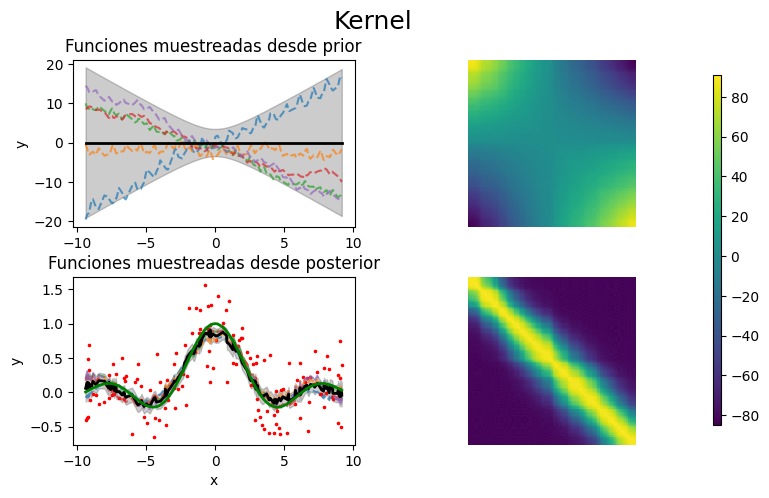

Kernel hiperparametros antes de entrenart:
1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) + 1**2 * ExpSineSquared(length_scale=1, periodicity=1))


Kernel hiperparametros después de entrenar: 
0.371**2 * RBF(length_scale=2.39) + 0.00305**2 * DotProduct(sigma_0=0.00229) + 0.105**2 * ExpSineSquared(length_scale=2.44, periodicity=0.0244) 
Log-likelihood: -114.690




In [9]:
#entrenar gpr
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct,ExpSineSquared, ConstantKernel
import matplotlib


#organizar datos para graficar
ind_ = np.argsort(X_test,axis=0).reshape(-1)

#definir gpr
alpha = 0.1#*1/np.var(y_train)#1e-5
#kernel
kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0))*RBF(length_scale=1,length_scale_bounds=(1e-1, 10.0))+ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0))*DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-05, 100000.0))+ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0))*ExpSineSquared(length_scale=1.0, periodicity=1.0, length_scale_bounds=(1e-05, 100000.0), periodicity_bounds=(1e-05, 100000.0))
#crear gpr
gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha, random_state=0)#crear objeto gpr

fig, axs = plt.subplots(nrows=2,  ncols=2, figsize=(8, 5))

# plot kernel prior
K_prior = kernel(X_test[ind_,0].reshape(-1,1),X_test[ind_,0].reshape(-1,1))
axs[0,1].imshow(K_prior)
axs[0,1].axis('off')

# plot prior
n_samples = 5
plot_gpr_samples(gpr, X_test[ind_,0].reshape(-1,1), X_test[ind_,0].ravel(),
                 n_samples=n_samples, ax=axs[0,0],xlabel_="")
axs[0,0].set_title("Funciones muestreadas desde prior")
#axs[0,0].set_ylim([-2,2])

# plot posterior
gpr.fit(X_train, y_train) #entrenar GPR en train

plot_gpr_samples(gpr,  X_test[ind_,0].reshape(-1,1), X_test[ind_,0].ravel(),
                 n_samples=n_samples, ax=axs[1,0])
axs[1,0].scatter(X_test[ind_, 0], y_test[ind_], color="red",marker='.',s=10)
axs[1,0].plot(X_test[ind_, 0], y[test_i][ind_], color="g",lw=2) #target ytest
axs[1,0].set_title("Funciones muestreadas desde posterior")

# plot kernel posterior después de entrenar
K_posterior = gpr.kernel_(X_test[ind_,0].reshape(-1,1),X_test[ind_,0].reshape(-1,1))
axs[1,1].imshow(K_posterior)
axs[1,1].axis('off')


cax = fig.add_axes([0.925, 0.15, 0.01, 0.7])
norm = matplotlib.colors.Normalize(vmin=min(np.append(K_prior.ravel(),K_posterior.ravel())),
                                   vmax=max(np.append(K_prior.ravel(),K_posterior.ravel())))
sm = plt.cm.ScalarMappable(cmap=None, norm=norm)
#sm.set_array([])
cbar = plt.colorbar(sm,cax=cax)


fig.suptitle("Kernel", fontsize=18)
plt.subplots_adjust(hspace=0.3)
#plt.tight_layout()

plt.show()

print(f"Kernel hiperparametros antes de entrenart:\n{kernel})")
print(
    f"\n\nKernel hiperparametros después de entrenar: \n{gpr.kernel_} \n"
    f"Log-likelihood: {gpr.log_marginal_likelihood(gpr.kernel_.theta):.3f}\n\n"
)



In [10]:
np.exp(gpr.kernel_.theta)#hiperparametros optimizados por el GPR

array([1.37360690e-01, 2.39002476e+00, 9.31832390e-06, 2.28575691e-03,
       1.10062981e-02, 2.43808723e+00, 2.44254912e-02])

*Y ahora modificamos los kernels que se van a usar*


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:357: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


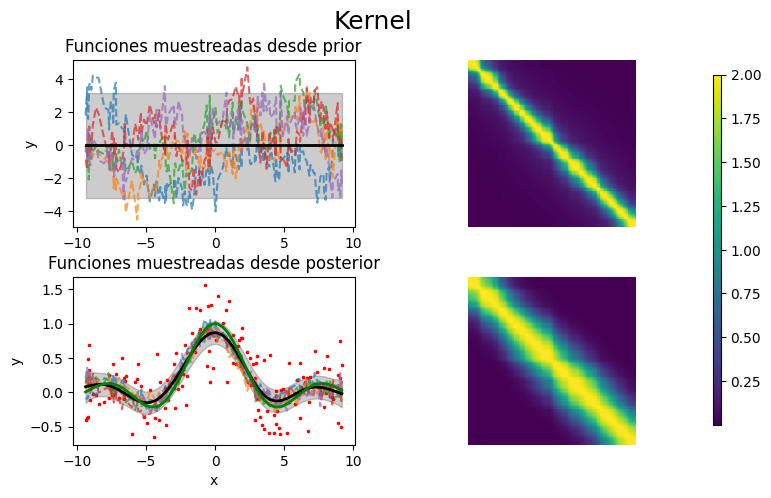

Kernel hiperparametros antes de entrenart:
1**2 * RBF(length_scale=1) + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * WhiteKernel(noise_level=0.5))


Kernel hiperparametros después de entrenar: 
0.369**2 * RBF(length_scale=2.4) + 0.000131**2 * RationalQuadratic(alpha=1.69, length_scale=6.54) + 0.0373**2 * WhiteKernel(noise_level=3.24) 
Log-likelihood: -116.327




In [14]:
#entrenar gpr
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct,ExpSineSquared, ConstantKernel, RationalQuadratic, WhiteKernel
import matplotlib


#organizar datos para graficar
ind_ = np.argsort(X_test,axis=0).reshape(-1)

#definir gpr
alpha = 0.1#*1/np.var(y_train)#1e-5
#kernel
kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0))*RBF(length_scale=1,length_scale_bounds=(1e-1, 10.0))+ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0))*RationalQuadratic(length_scale=1,length_scale_bounds=(1e-1, 10.0))+ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0))*WhiteKernel(noise_level=0.5)
#crear gpr
gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha, random_state=0)#crear objeto gpr

fig, axs = plt.subplots(nrows=2,  ncols=2, figsize=(8, 5))

# plot kernel prior
K_prior = kernel(X_test[ind_,0].reshape(-1,1),X_test[ind_,0].reshape(-1,1))
axs[0,1].imshow(K_prior)
axs[0,1].axis('off')

# plot prior
n_samples = 5
plot_gpr_samples(gpr, X_test[ind_,0].reshape(-1,1), X_test[ind_,0].ravel(),
                 n_samples=n_samples, ax=axs[0,0],xlabel_="")
axs[0,0].set_title("Funciones muestreadas desde prior")
#axs[0,0].set_ylim([-2,2])

# plot posterior
gpr.fit(X_train, y_train) #entrenar GPR en train

plot_gpr_samples(gpr,  X_test[ind_,0].reshape(-1,1), X_test[ind_,0].ravel(),
                 n_samples=n_samples, ax=axs[1,0])
axs[1,0].scatter(X_test[ind_, 0], y_test[ind_], color="red",marker='.',s=10)
axs[1,0].plot(X_test[ind_, 0], y[test_i][ind_], color="g",lw=2) #target ytest
axs[1,0].set_title("Funciones muestreadas desde posterior")

# plot kernel posterior después de entrenar
K_posterior = gpr.kernel_(X_test[ind_,0].reshape(-1,1),X_test[ind_,0].reshape(-1,1))
axs[1,1].imshow(K_posterior)
axs[1,1].axis('off')


cax = fig.add_axes([0.925, 0.15, 0.01, 0.7])
norm = matplotlib.colors.Normalize(vmin=min(np.append(K_prior.ravel(),K_posterior.ravel())),
                                   vmax=max(np.append(K_prior.ravel(),K_posterior.ravel())))
sm = plt.cm.ScalarMappable(cmap=None, norm=norm)
#sm.set_array([])
cbar = plt.colorbar(sm,cax=cax)


fig.suptitle("Kernel", fontsize=18)
plt.subplots_adjust(hspace=0.3)
#plt.tight_layout()

plt.show()

print(f"Kernel hiperparametros antes de entrenart:\n{kernel})")
print(
    f"\n\nKernel hiperparametros después de entrenar: \n{gpr.kernel_} \n"
    f"Log-likelihood: {gpr.log_marginal_likelihood(gpr.kernel_.theta):.3f}\n\n"
)



*A pesar de que el kernel RBF o gaussiano es el que da la forma de la solucion principalmente, se nota bastante el cambio de los otros 2 kernels. El kernel exponencial sin era el segundo que más aportaba a la solución, mientras los 2 nuevos elegidos (rationalquadratic y whitekernel) no aportaron practicamente nada.*

**Ejercicio 4 - Variacion del parametro alpha**

*Definimos el mismo gp que antes, con los mismos kernels, pero variamos el parametro alpha a uno mucho mayor*

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:357: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


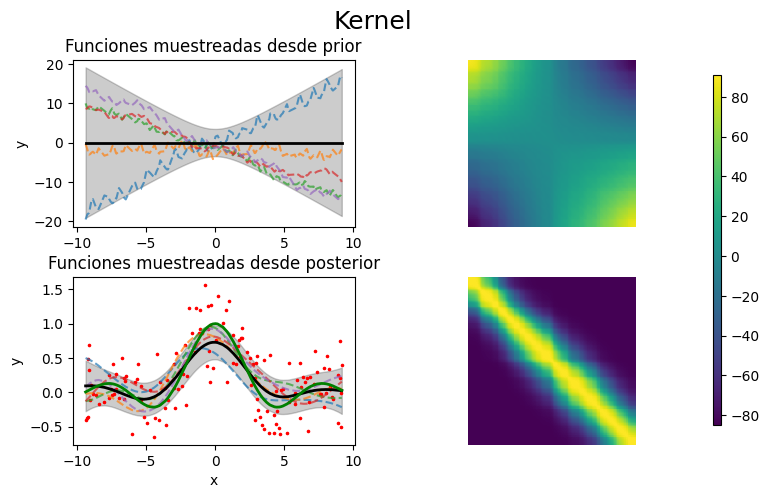

Kernel hiperparametros antes de entrenart:
1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) + 1**2 * ExpSineSquared(length_scale=1, periodicity=1))


Kernel hiperparametros después de entrenar: 
0.335**2 * RBF(length_scale=2.34) + 3.21e-05**2 * DotProduct(sigma_0=0.000104) + 0.00407**2 * ExpSineSquared(length_scale=1e+05, periodicity=0.0341) 
Log-likelihood: -349.359




In [15]:
#entrenar gpr
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct,ExpSineSquared, ConstantKernel
import matplotlib


#organizar datos para graficar
ind_ = np.argsort(X_test,axis=0).reshape(-1)

#definir gpr
alpha = 1#*1/np.var(y_train)#1e-5
#kernel
kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0))*RBF(length_scale=1,length_scale_bounds=(1e-1, 10.0))+ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0))*DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-05, 100000.0))+ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0))*ExpSineSquared(length_scale=1.0, periodicity=1.0, length_scale_bounds=(1e-05, 100000.0), periodicity_bounds=(1e-05, 100000.0))
#crear gpr
gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha, random_state=0)#crear objeto gpr

fig, axs = plt.subplots(nrows=2,  ncols=2, figsize=(8, 5))

# plot kernel prior
K_prior = kernel(X_test[ind_,0].reshape(-1,1),X_test[ind_,0].reshape(-1,1))
axs[0,1].imshow(K_prior)
axs[0,1].axis('off')

# plot prior
n_samples = 5
plot_gpr_samples(gpr, X_test[ind_,0].reshape(-1,1), X_test[ind_,0].ravel(),
                 n_samples=n_samples, ax=axs[0,0],xlabel_="")
axs[0,0].set_title("Funciones muestreadas desde prior")
#axs[0,0].set_ylim([-2,2])

# plot posterior
gpr.fit(X_train, y_train) #entrenar GPR en train

plot_gpr_samples(gpr,  X_test[ind_,0].reshape(-1,1), X_test[ind_,0].ravel(),
                 n_samples=n_samples, ax=axs[1,0])
axs[1,0].scatter(X_test[ind_, 0], y_test[ind_], color="red",marker='.',s=10)
axs[1,0].plot(X_test[ind_, 0], y[test_i][ind_], color="g",lw=2) #target ytest
axs[1,0].set_title("Funciones muestreadas desde posterior")

# plot kernel posterior después de entrenar
K_posterior = gpr.kernel_(X_test[ind_,0].reshape(-1,1),X_test[ind_,0].reshape(-1,1))
axs[1,1].imshow(K_posterior)
axs[1,1].axis('off')


cax = fig.add_axes([0.925, 0.15, 0.01, 0.7])
norm = matplotlib.colors.Normalize(vmin=min(np.append(K_prior.ravel(),K_posterior.ravel())),
                                   vmax=max(np.append(K_prior.ravel(),K_posterior.ravel())))
sm = plt.cm.ScalarMappable(cmap=None, norm=norm)
#sm.set_array([])
cbar = plt.colorbar(sm,cax=cax)


fig.suptitle("Kernel", fontsize=18)
plt.subplots_adjust(hspace=0.3)
#plt.tight_layout()

plt.show()

print(f"Kernel hiperparametros antes de entrenart:\n{kernel})")
print(
    f"\n\nKernel hiperparametros después de entrenar: \n{gpr.kernel_} \n"
    f"Log-likelihood: {gpr.log_marginal_likelihood(gpr.kernel_.theta):.3f}\n\n"
)



*Ahora a un alpha mucho más pequeño*

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:357: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


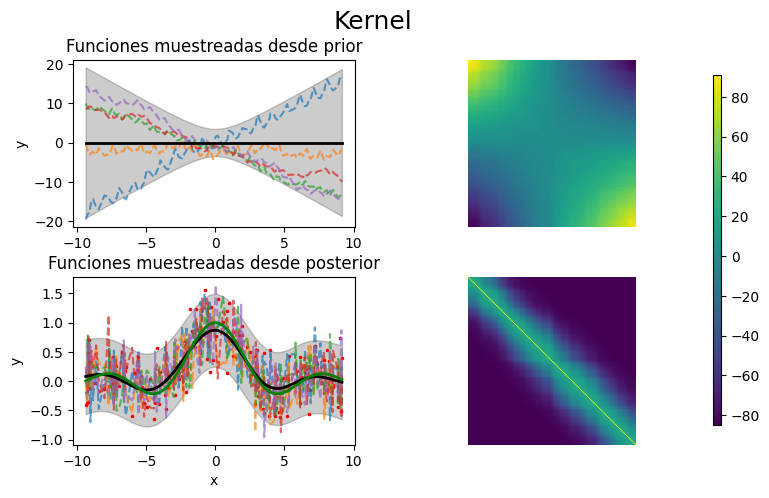

Kernel hiperparametros antes de entrenart:
1**2 * RBF(length_scale=1) + 1**2 * DotProduct(sigma_0=1) + 1**2 * ExpSineSquared(length_scale=1, periodicity=1))


Kernel hiperparametros después de entrenar: 
0.369**2 * RBF(length_scale=2.4) + 1.95e-08**2 * DotProduct(sigma_0=4.36e+03) + 0.307**2 * ExpSineSquared(length_scale=1e-05, periodicity=0.634) 
Log-likelihood: -116.327




In [16]:
#entrenar gpr
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct,ExpSineSquared, ConstantKernel
import matplotlib


#organizar datos para graficar
ind_ = np.argsort(X_test,axis=0).reshape(-1)

#definir gpr
alpha = 0.01#*1/np.var(y_train)#1e-5
#kernel
kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0))*RBF(length_scale=1,length_scale_bounds=(1e-1, 10.0))+ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0))*DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-05, 100000.0))+ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0))*ExpSineSquared(length_scale=1.0, periodicity=1.0, length_scale_bounds=(1e-05, 100000.0), periodicity_bounds=(1e-05, 100000.0))
#crear gpr
gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha, random_state=0)#crear objeto gpr

fig, axs = plt.subplots(nrows=2,  ncols=2, figsize=(8, 5))

# plot kernel prior
K_prior = kernel(X_test[ind_,0].reshape(-1,1),X_test[ind_,0].reshape(-1,1))
axs[0,1].imshow(K_prior)
axs[0,1].axis('off')

# plot prior
n_samples = 5
plot_gpr_samples(gpr, X_test[ind_,0].reshape(-1,1), X_test[ind_,0].ravel(),
                 n_samples=n_samples, ax=axs[0,0],xlabel_="")
axs[0,0].set_title("Funciones muestreadas desde prior")
#axs[0,0].set_ylim([-2,2])

# plot posterior
gpr.fit(X_train, y_train) #entrenar GPR en train

plot_gpr_samples(gpr,  X_test[ind_,0].reshape(-1,1), X_test[ind_,0].ravel(),
                 n_samples=n_samples, ax=axs[1,0])
axs[1,0].scatter(X_test[ind_, 0], y_test[ind_], color="red",marker='.',s=10)
axs[1,0].plot(X_test[ind_, 0], y[test_i][ind_], color="g",lw=2) #target ytest
axs[1,0].set_title("Funciones muestreadas desde posterior")

# plot kernel posterior después de entrenar
K_posterior = gpr.kernel_(X_test[ind_,0].reshape(-1,1),X_test[ind_,0].reshape(-1,1))
axs[1,1].imshow(K_posterior)
axs[1,1].axis('off')


cax = fig.add_axes([0.925, 0.15, 0.01, 0.7])
norm = matplotlib.colors.Normalize(vmin=min(np.append(K_prior.ravel(),K_posterior.ravel())),
                                   vmax=max(np.append(K_prior.ravel(),K_posterior.ravel())))
sm = plt.cm.ScalarMappable(cmap=None, norm=norm)
#sm.set_array([])
cbar = plt.colorbar(sm,cax=cax)


fig.suptitle("Kernel", fontsize=18)
plt.subplots_adjust(hspace=0.3)
#plt.tight_layout()

plt.show()

print(f"Kernel hiperparametros antes de entrenart:\n{kernel})")
print(
    f"\n\nKernel hiperparametros después de entrenar: \n{gpr.kernel_} \n"
    f"Log-likelihood: {gpr.log_marginal_likelihood(gpr.kernel_.theta):.3f}\n\n"
)



*El principal cambio al modificar el parametro alpha es la sombra de fiabilidad de los datos, o la varianza de las soluciones, al aumentarlo 10 veces empeoro un poco ese margen de error, pero al disminuirlo 10 veces empeoró bastante.*

**Ejercicio 5 - GP para una señal diferente**

*Primero usamos gemini para generar la funcion target especificada en el ejercicio*

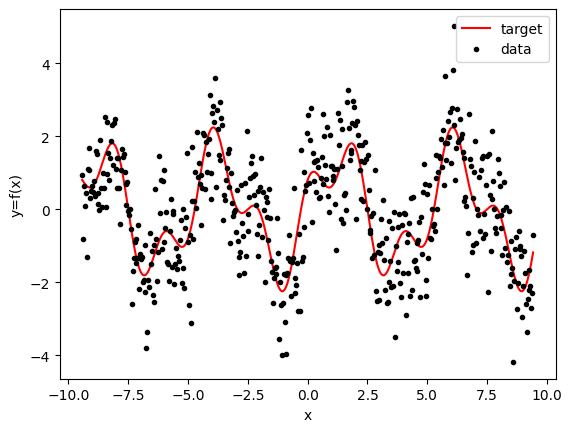

0


In [18]:
# prompt: I want to change the target defined in te current notebook to y= Asin(2piF1xn)+Bcos(2piF2xn)+nn, with A and B Real constants and nn white noise that follows the SNR relation of 2 db

# Define parameters for the new target function
A = 1.5  # Amplitude of the sine wave
B = 0.8  # Amplitude of the cosine wave
F1 = 0.2  # Frequency of the sine wave
F2 = 0.5  # Frequency of the cosine wave
SNR_db = 2  # Signal-to-noise ratio in dB

# Calculate the noise variance based on the SNR
SNR_linear = 10**(SNR_db / 10)
signal_power = np.mean(A**2 * np.sin(2 * np.pi * F1 * X)**2 + B**2 * np.cos(2 * np.pi * F2 * X)**2)
noise_power = signal_power / SNR_linear
noise_variance = noise_power


# Generate the new target function with white noise
y = A * np.sin(2 * np.pi * F1 * X) + B * np.cos(2 * np.pi * F2 * X)
noise = np.sqrt(noise_variance) * np.random.randn(X.shape[0])
yn = y + noise

#Now you can use yn as your new target for further processing.
#For example replace the old yn with new yn.
plt.plot(X, y, 'r', label='target')
plt.plot(X, yn, 'k.', label='data')
plt.legend()
plt.xlabel('x')
plt.ylabel('y=f(x)')
plt.show()

#Reshape the data like before
ydata = yn.reshape(-1, 1)
Xdata = X.reshape(-1, 1)

#Re-split your data
rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.3)
for i, (train_i, test_i) in enumerate(rs.split(X)):
    print(i)

X_train, X_test, y_train, y_test = Xdata[train_i], Xdata[test_i], ydata[train_i], ydata[test_i]

#You can continue with the rest of your code using X_train, X_test, y_train, y_test

*Y ahora simplemente volvemos a entrenar el GP con los nuevos datos de target, tambien se cambio el kernel dotproduct por el rationalcuadratic que aportó más a la solución*

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:357: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


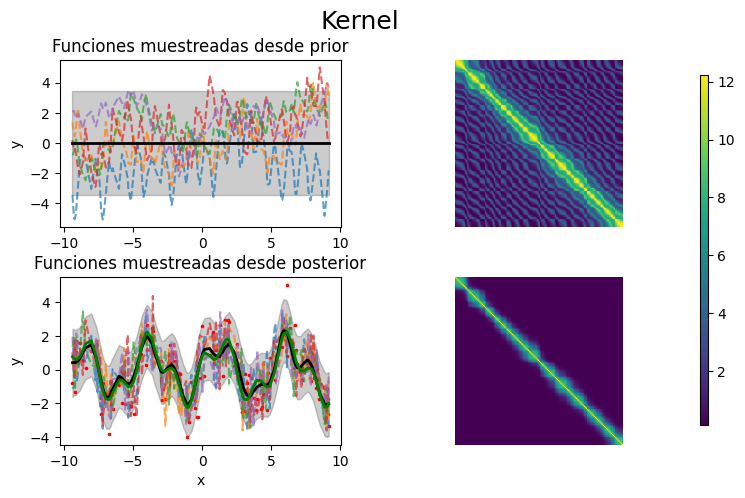

Kernel hiperparametros antes de entrenart:
1**2 * RBF(length_scale=1) + 1**2 * RationalQuadratic(alpha=1, length_scale=1) + 1**2 * ExpSineSquared(length_scale=1, periodicity=1))


Kernel hiperparametros después de entrenar: 
1.29**2 * RBF(length_scale=0.633) + 3.13**2 * RationalQuadratic(alpha=1e-05, length_scale=0.1) + 0.897**2 * ExpSineSquared(length_scale=1.03e-05, periodicity=2.09) 
Log-likelihood: -519.920




In [20]:
#entrenar gpr
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct,ExpSineSquared, ConstantKernel
import matplotlib


#organizar datos para graficar
ind_ = np.argsort(X_test,axis=0).reshape(-1)

#definir gpr
alpha = 0.1#*1/np.var(y_train)#1e-5
#kernel
kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0))*RBF(length_scale=1,length_scale_bounds=(1e-1, 10.0))+ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0))*RationalQuadratic(length_scale=1,length_scale_bounds=(1e-1, 10.0))+ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0))*ExpSineSquared(length_scale=1.0, periodicity=1.0, length_scale_bounds=(1e-05, 100000.0), periodicity_bounds=(1e-05, 100000.0))
#crear gpr
gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha, random_state=0)#crear objeto gpr

fig, axs = plt.subplots(nrows=2,  ncols=2, figsize=(8, 5))

# plot kernel prior
K_prior = kernel(X_test[ind_,0].reshape(-1,1),X_test[ind_,0].reshape(-1,1))
axs[0,1].imshow(K_prior)
axs[0,1].axis('off')

# plot prior
n_samples = 5
plot_gpr_samples(gpr, X_test[ind_,0].reshape(-1,1), X_test[ind_,0].ravel(),
                 n_samples=n_samples, ax=axs[0,0],xlabel_="")
axs[0,0].set_title("Funciones muestreadas desde prior")
#axs[0,0].set_ylim([-2,2])

# plot posterior
gpr.fit(X_train, y_train) #entrenar GPR en train

plot_gpr_samples(gpr,  X_test[ind_,0].reshape(-1,1), X_test[ind_,0].ravel(),
                 n_samples=n_samples, ax=axs[1,0])
axs[1,0].scatter(X_test[ind_, 0], y_test[ind_], color="red",marker='.',s=10)
axs[1,0].plot(X_test[ind_, 0], y[test_i][ind_], color="g",lw=2) #target ytest
axs[1,0].set_title("Funciones muestreadas desde posterior")

# plot kernel posterior después de entrenar
K_posterior = gpr.kernel_(X_test[ind_,0].reshape(-1,1),X_test[ind_,0].reshape(-1,1))
axs[1,1].imshow(K_posterior)
axs[1,1].axis('off')


cax = fig.add_axes([0.925, 0.15, 0.01, 0.7])
norm = matplotlib.colors.Normalize(vmin=min(np.append(K_prior.ravel(),K_posterior.ravel())),
                                   vmax=max(np.append(K_prior.ravel(),K_posterior.ravel())))
sm = plt.cm.ScalarMappable(cmap=None, norm=norm)
#sm.set_array([])
cbar = plt.colorbar(sm,cax=cax)


fig.suptitle("Kernel", fontsize=18)
plt.subplots_adjust(hspace=0.3)
#plt.tight_layout()

plt.show()

print(f"Kernel hiperparametros antes de entrenart:\n{kernel})")
print(
    f"\n\nKernel hiperparametros después de entrenar: \n{gpr.kernel_} \n"
    f"Log-likelihood: {gpr.log_marginal_likelihood(gpr.kernel_.theta):.3f}\n\n"
)



*Si bien tiene más varianza que para los datos anteriores. Considerando que esta señal es bastante más compleja, el resultado es satisfactorio*